# 14 - ANOVA

<center><img src="img/anovaa.png" alt="Testy różnic" width="500"/></center>

# ANOVA w Pythonie – wprowadzenie

Analiza wariancji (**ANOVA**, *Analysis of Variance*) służy do sprawdzania, czy **średnie kilku niezależnych grup** różnią się od siebie istotnie statystycznie. Porównujemy dwa źródła zmienności:

- **Między grupami (Between Groups)** – zmienność wynikająca z różnic między średnimi grup  
- **Wewnątrz grup (Within Groups / Residual)** – zmienność wynikająca z indywidualnych różnic w obrębie każdej grupy  

Statystyka testowa ma postać:

$$
F = \frac{MS_{\text{between}}}{MS_{\text{within}}}
$$

gdzie:

$$
MS = \frac{SS}{df}
$$

Duża wartość statystyki *F* sugeruje, że średnie w grupach różnią się bardziej, niż wynikałoby to z przypadku.

---

## Hipotezy w jednoczynnikowej ANOVA

- **H₀:** wszystkie średnie populacyjne są równe  
$$
  \mu_1 = \mu_2 = \dots = \mu_k
$$

- **H₁:** co najmniej dwie średnie różnią się między sobą

---

## Tabela ANOVA 

| Źródło zmienności | SS (Sum of Squares) | df  | MS (Mean Square)              | F                           | p-value |
|-------------------|---------------------|-----|-------------------------------|-----------------------------|---------|
| Between Groups    | SS_between          | k-1 | SS_between/(k-1)              | MS_between/MS_within        | p       |
| Within Groups     | SS_within           | N-k | SS_within/(N-k)               | —                           | —       |
| Total             | SS_total            | N-1 | —                             | —                           | —       |

Gdzie:  
- `k` – liczba porównywanych grup  
- `N` – łączna liczba obserwacji

---

<center><img src="img/anova.png" alt="Testy różnic" width="500"/></center>

---

## Przykład 1.

Dane pochodzą z amerykańskiego magazynu Motor Trend z 1974 roku i obejmują zużycie paliwa oraz 10 cech związanych z konstrukcją i osiągami 32 samochodów (modele z lat 1973–74).

W analizie chcemy rozważyć możliwe różnice w liczbie mil na galon (mpg) pomiędzy wybranymi grupami kontrolnymi, takimi jak liczba cylindrów.

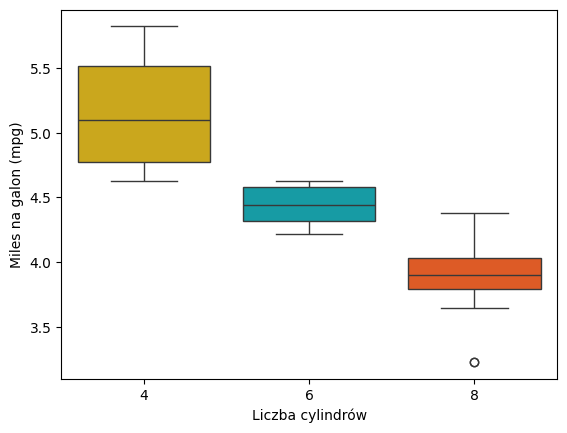

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Wczytanie danych mtcars
url = "https://raw.githubusercontent.com/selva86/datasets/master/mtcars.csv"
mtcars = pd.read_csv(url)

# Zamiana liczby cylindrów na tekst
mtcars['cyl'] = mtcars['cyl'].astype(str)

# Wykres pudełkowy zgodny z nowszą wersją seaborn
sns.boxplot(
    x='cyl',
    y='mpg',
    hue='cyl',          # <- wymagane, jeśli używasz palette
    data=mtcars,
    palette=["#00AFBB", "#E7B800", "#FC4E07"],
    order=["4", "6", "8"],
    legend=False        # <- wyłącza niepotrzebną legendę
)

plt.xlabel("Liczba cylindrów")
plt.ylabel("Miles na galon (mpg)")

plt.show()


Zacznijmy najpierw od spojrzenia na przedziały ufności:

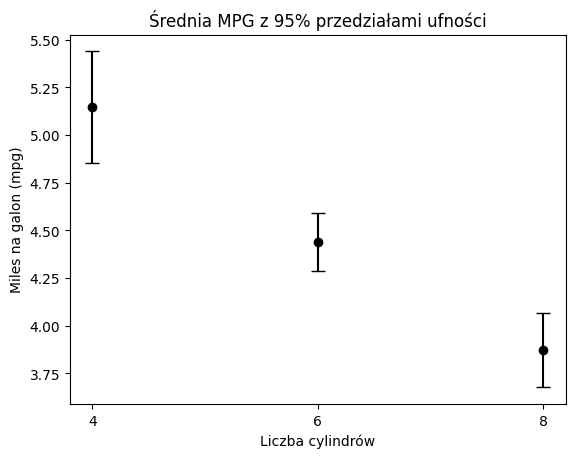

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.weightstats import DescrStatsW

# Obliczenie średnich i 95% CI dla mpg w grupach cylindrów
means = mtcars.groupby('cyl')['mpg'].mean()
conf_intervals = mtcars.groupby('cyl')['mpg'].apply(lambda x: DescrStatsW(x).tconfint_mean())

# Ekstrakcja dolnej i górnej granicy CI
lower_bounds = conf_intervals.apply(lambda x: x[0])
upper_bounds = conf_intervals.apply(lambda x: x[1])

# Wykres punktowy ze słupkami błędów (95% CI)
plt.errorbar(
    means.index,
    means,
    yerr=[means - lower_bounds, upper_bounds - means],
    fmt='o',
    capsize=5,
    color='black'
)

plt.xlabel("Liczba cylindrów")
plt.ylabel("Miles na galon (mpg)")
plt.title("Średnia MPG z 95% przedziałami ufności")

plt.show()


### 1-way Anova

Chcemy sprawdzić, czy istnieją jakiekolwiek istotne różnice pomiędzy średnią liczbą mil na galon w trzech typach samochodów (różniących się liczbą cylindrów).

Zacznijmy od sprawdzenia normalności rozkładu.

In [5]:
import pandas as pd
from scipy.stats import shapiro

# Grupujemy dane wg liczby cylindrów ('cyl') i wykonujemy test Shapiro–Wilka
# dla zmiennej 'mpg' w każdej grupie
shapiro_results = mtcars.groupby('cyl')['mpg'].apply(lambda x: shapiro(x))

# Tworzymy DataFrame z wynikami testu
shapiro_df = pd.DataFrame({
    'cyl': shapiro_results.index,
    'W': [result[0] for result in shapiro_results],
    'p-value': [result[1] for result in shapiro_results]
})

print(shapiro_df)


  cyl         W   p-value
0   4  0.915339  0.281708
1   6  0.898284  0.320719
2   8  0.915158  0.187208


Możemy również obejrzeć wykresy Q–Q sprawdzające normalność, razem z wynikami testu Shapiro–Wilka:

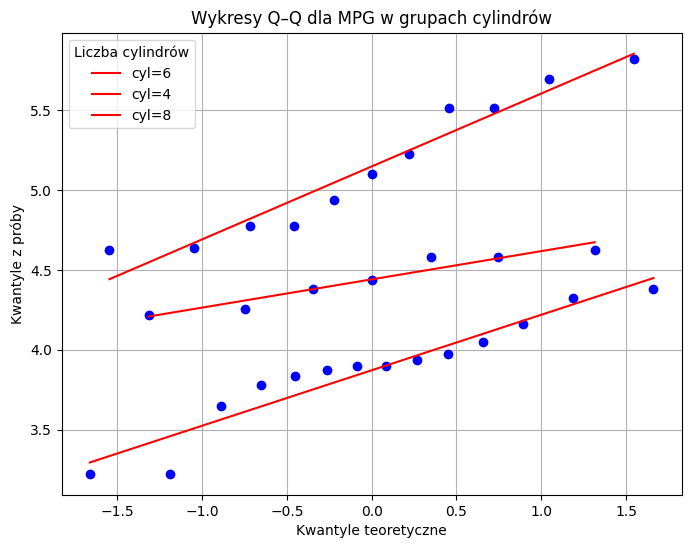

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Tworzymy wykresy Q–Q z linią odniesienia dla każdej grupy cylindrów
plt.figure(figsize=(8, 6))
for cyl in mtcars['cyl'].unique():
    subset = mtcars[mtcars['cyl'] == cyl]
    stats.probplot(subset['mpg'], dist="norm", plot=plt)
    plt.gca().get_lines()[-1].set_label(f'cyl={cyl}')  # etykieta dla legendy

plt.legend(title='Liczba cylindrów')
plt.xlabel('Kwantyle teoretyczne')
plt.ylabel('Kwantyle z próby')
plt.title('Wykresy Q–Q dla MPG w grupach cylindrów')
plt.grid(True)
plt.show()


- Nie widzimy żadnych odchyleń od linii normalności, a wartości p również sugerują brak podstaw do odrzucenia normalności.

- Kolejnym krokiem jest przetestowanie założenia o jednorodności wariancji. 

- Zdecydowanie polecam test Levene’a, który jest mniej wrażliwy na odchylenia od normalnego rozkładu.

In [8]:
from scipy.stats import levene
# Wykonanie testu Levene’a na równość wariancji
stat, p_value = levene(
    mtcars[mtcars['cyl'] == '4']['mpg'],
    mtcars[mtcars['cyl'] == '6']['mpg'],
    mtcars[mtcars['cyl'] == '8']['mpg']
)

print(f"Statystyka testu Levene’a: {stat}")
print(f"Wartość p: {p_value}")

Statystyka testu Levene’a: 2.868889131775262
Wartość p: 0.07296950644913475


Wartość p jest tylko nieco wyższa od naszego progu istotności α = 0.05, więc jeśli chcesz przeprowadzić bardziej odporną wersję ANOVA — czyli ANOVA Welcha — uruchom funkcję z biblioteki pingouin:

In [9]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Perform ANOVA using statsmodels
model = ols('mpg ~ cyl', data=mtcars).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

# Display the ANOVA table
print(anova_results)

             sum_sq    df          F        PR(>F)
cyl       10.013559   2.0  41.055426  3.477779e-09
Residual   3.536600  29.0        NaN           NaN


Jak widzimy, co najmniej jedna para średnich różni się istotnie statystycznie (H0 powinna zostać odrzucona). Oznacza to, że liczba mil na galon istotnie różni się pomiędzy samochodami o różnej liczbie cylindrów.

Skoro odrzuciliśmy H0, możemy przeprowadzić testy post-hoc: LSD (least-significant-differences) lub HSD (honestly-significant-differences).

Test Tukeya HSD służy do porównania wszystkich grup ze sobą — czyli wykonuje wszystkie możliwe porównania par 2 grup.

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     4      6  -0.7064 0.0007 -1.1234 -0.2894   True
     4      8   -1.275    0.0 -1.6224 -0.9275   True
     6      8  -0.5686  0.004 -0.9678 -0.1693   True
----------------------------------------------------


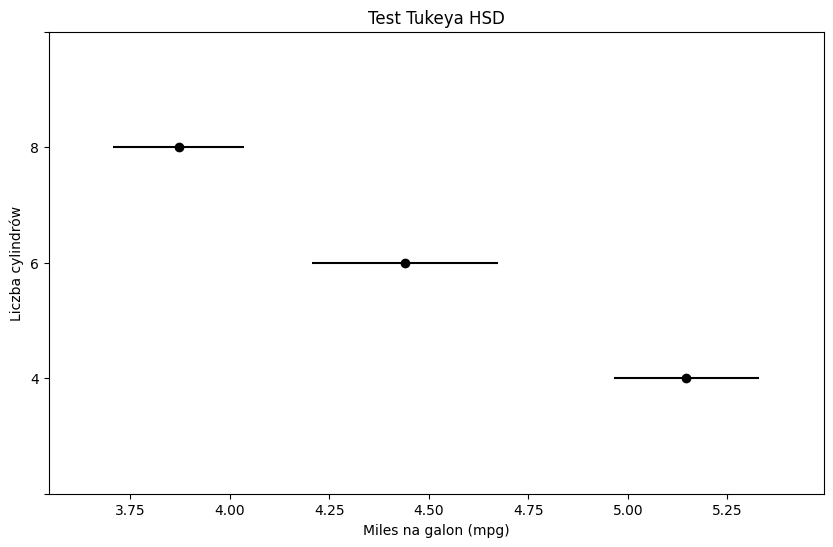

In [10]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

# Wykonanie testu Tukeya HSD
tukey = pairwise_tukeyhsd(endog=mtcars['mpg'], groups=mtcars['cyl'], alpha=0.05)

# Wyświetlenie wyników
print(tukey)

# Wykres wyników testu
tukey.plot_simultaneous()
plt.title('Test Tukeya HSD')
plt.xlabel('Miles na galon (mpg)')
plt.ylabel('Liczba cylindrów')
plt.show()


Jak widzimy powyżej, wszystkie pary średnich różnią się istotnie statystycznie (p < α).

Na koniec zwizualizujmy nasze wyniki razem z testem ANOVA oraz testami post-hoc:

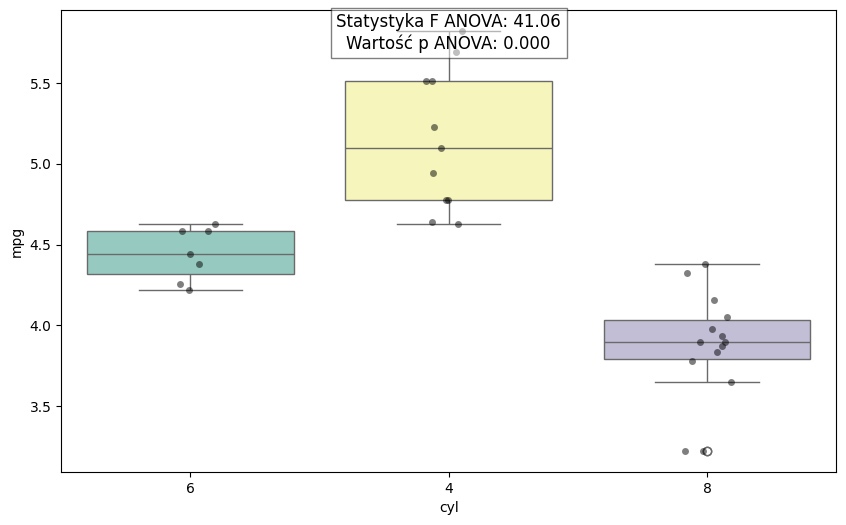

In [12]:
# Wykonanie testu Tukeya HSD
tukey = pairwise_tukeyhsd(endog=mtcars['mpg'], groups=mtcars['cyl'], alpha=0.05)

# Wizualizacja wyników
plt.figure(figsize=(10, 6))

# Boxplot: nowe wymagania seaborn
sns.boxplot(
    x='cyl',
    y='mpg',
    hue='cyl',
    data=mtcars,
    palette="Set3",
    legend=False
)

sns.stripplot(
    x='cyl',
    y='mpg',
    data=mtcars,
    color='black',
    jitter=True,
    alpha=0.5
)

# Dodanie wyników ANOVA
anova_text = (
    f"Statystyka F ANOVA: {anova_results['F'].iloc[0]:.2f}\n"
    f"Wartość p ANOVA: {anova_results['PR(>F)'].iloc[0]:.3f}"
)

plt.text(
    0.5, 0.95, anova_text,
    horizontalalignment='center',
    verticalalignment='center',
    transform=plt.gca().transAxes,
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.5)
)

plt.show()


Zrób to sam (DIY):

A co z am (typ skrzyni biegów) i liczbą biegów (gear)?

In [13]:
# Twój kod tutaj!

---

## Zadanie 1. Twoja kolej!

Poniższy zbiór danych przedstawia wyniki dotyczące satysfakcji z pracy, uporządkowane według płci oraz poziomu wykształcenia.

W tym badaniu badacz chce ocenić, czy istnieje istotna dwuczynnikowa interakcja pomiędzy płcią a poziomem wykształcenia w wyjaśnianiu poziomu satysfakcji z pracy.

Efekt interakcji pojawia się wtedy, gdy wpływ jednej zmiennej niezależnej na zmienną wynikową zależy od poziomu drugiej zmiennej niezależnej.

Jeśli efektu interakcji nie ma, można raportować efekty główne.


In [14]:
import pandas as pd

# Wczytanie zbioru danych jobsatisfaction z mojego repozytorium GitHub:
url = "https://raw.githubusercontent.com/kflisikowski/ds/master/jobsatisfaction.csv"
jobsatisfaction = pd.read_csv(url)

In [15]:
# Twój kod tutaj!

---